In [1]:
from skykatana import SkyMaskPipe
from pathlib import Path
import matplotlib.pyplot as plt

# Indepth Usage Guide
This notebook provides more detailed information about Skykatana usage and options. For a quick intro see quick_example_hsc.ipynb

--------------------------

## Define inputs

In [2]:
BASEPATH = Path('../example_data')

# Input hipscatted catalog (these are HSC galaxies)
HIPCAT = BASEPATH / 'hscx_minispring_gal/'

# Bright star regions of HSC
STARS_REGIONS     = BASEPATH / 'hsc_aux/stars_iband.parquet' 
BOX_STARS_REGIONS = BASEPATH / 'hsc_aux/starboxes_iband.parquet' 

# HSC patches and QA patch list ###################################### 
# See https://hsc-release.mtk.nao.ac.jp/schema/#pdr3.pdr3_wide.patch_qa
PATCH_FILE     = [BASEPATH / 'hsc_aux/tracts_patches_spring.parquet']  # the complete Spring region of HSC
QA_FILE        = BASEPATH / 'hsc_aux/patch_qa.csv'

# Extended sources to mask out
ELLIP_REGIONS = BASEPATH / 'hsc_aux/extended_sources.dat'

# User defined masks
USER_CIRCLE_REGIONS = BASEPATH / 'hsc_aux/user_circs.dat' 
USER_POLY_REGIONS   = BASEPATH / 'hsc_aux/user_polys.dat'

## 1. Creating footprint maps
-------------

The first stage is creating footprint maps by pixelizing an input catalog of sources with `buid_footprint_map()`. This catalog should be dense enough in order to not produce artificial holes but still trace well the boundaries and real holes. You can customize `order_foot` for that.

<p style="color:tomato">Attribute created --> SkyMaskPipe.foot</p>

What should be the input catalog then? Suppose you are working a sample of extremely red galaxies with some color cuts in gri bands. The input catalog would be all HSC objects selected as galaxies with gri coverage, i.e. the parent sample from which red galaxies where drawn from

In [3]:
mkp_order8 = SkyMaskPipe()
mkp_order8.build_footprint_mask(hipcat=HIPCAT, order_foot=8)
mkp_order13 = SkyMaskPipe()
mkp_order13.build_footprint_mask(hipcat=HIPCAT, order_foot=13)
mkp_order16 = SkyMaskPipe()
mkp_order16.build_footprint_mask(hipcat=HIPCAT, order_foot=16)

BUILDING FOOTPRINT MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating hipscat catalog from: ../example_data/hscx_minispring_gal
    Order :: 8
--- Footprint map area                    : 72.59890031076593
BUILDING FOOTPRINT MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating hipscat catalog from: ../example_data/hscx_minispring_gal
    Order :: 13
--- Footprint map area                    : 65.03291193694062
BUILDING FOOTPRINT MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating hipscat catalog from: ../example_data/hscx_minispring_gal
    Order :: 16
--- Footprint map area                    : 6.037364023128678


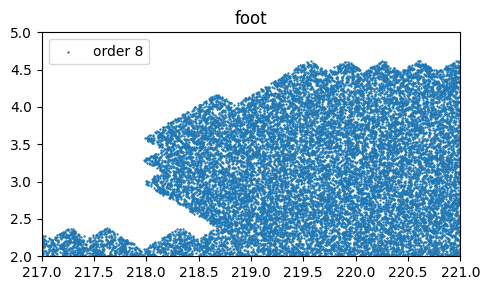

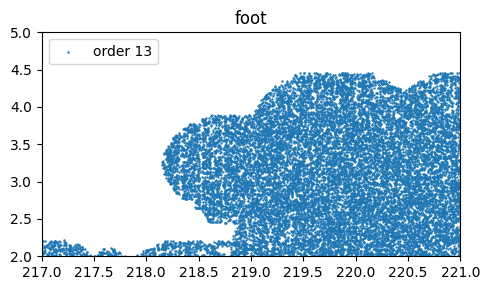

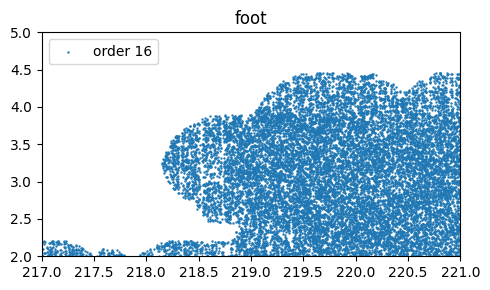

In [4]:
mkp_order8.plot(stage='foot', nr=200_000, figsize=[5,3], xwin=[217,221], ywin=[2,5])
plt.legend(["order 8"], loc='upper left')

mkp_order13.plot(stage='foot', nr=200_000,figsize=[5,3], xwin=[217,221], ywin=[2,5])
plt.legend(["order 13"], loc='upper left')

mkp_order16.plot(stage='foot', nr=200_000,figsize=[5,3], xwin=[217,221], ywin=[2,5])
plt.legend(["order 16"], loc='upper left')

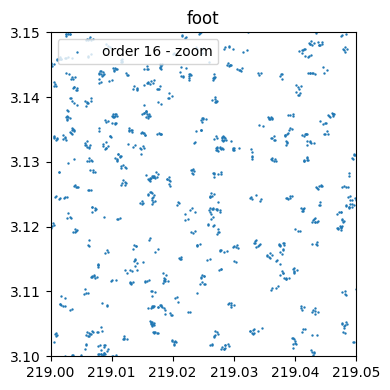

In [5]:
mkp_order16.plot(stage='foot', nr=30_000_000, figsize=[4,4], xwin=[219,219.05], ywin=[3.10,3.15])
plt.legend(["order 16 - zoom"], loc='upper left')

At `order_foot=16`, this is clearly overpizelixed and your mask is basically made of tiny pixels around the real galaxy positions whose area sums barely to ~6 deg^2 

In [6]:
mkp_order16.foot.get_valid_area()

6.037364023128678

### 1.1 Remove isolated pixels
------------

An isolated empty pixel is a pixel set to False surrounded by 8 True pixels. If `order_foot` is so that you start seeing some (individual pixel) holes artificially induced, setting `remove_isopixels=True` can detect these, and set these pixels on again (i.e. set to True).

Next, we compare two footprint maps pixelated at order=13, without and with removal of isolated pixels

In [11]:
mkp_order13 = SkyMaskPipe()
mkp_order13.build_footprint_mask(hipcat=HIPCAT, order_foot=13)

BUILDING FOOTPRINT MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating hipscat catalog from: ../example_data/hscx_minispring_gal
    Order :: 13
--- Footprint map area                    : 65.03291193694062


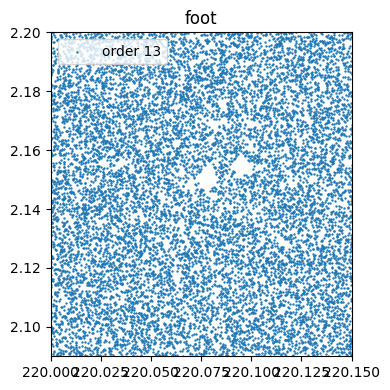

In [12]:
mkp_order13.plot(stage='foot', nr=50_000_000, figsize=[4,4], xwin=[220.0,220.15], ywin=[2.09,2.20])
plt.legend(["order 13"], loc='upper left')

In [13]:
mkp_order13_noiso = SkyMaskPipe()
mkp_order13_noiso.build_footprint_mask(hipcat=HIPCAT, order_foot=13, remove_isopixels=True)

BUILDING FOOTPRINT MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating hipscat catalog from: ../example_data/hscx_minispring_gal
    Order :: 13
    ...removing isolated pixels...


100%|█████████████████████████████████████████████████████████████████████| 1269519/1269519 [00:09<00:00, 136087.93it/s]


--- Footprint map area                    : 65.42684309732111


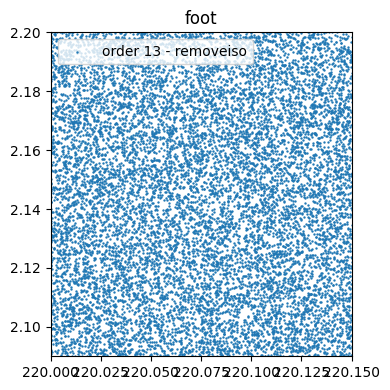

In [14]:
mkp_order13_noiso.plot(stage='foot', nr=50_000_000, figsize=[4,4], xwin=[220.0,220.15], ywin=[2.09,2.20])
plt.legend(["order 13 - removeiso"], loc='upper left')

### 1.2 Erode borders
---------------

Since there is a pixelization involved, it is inevitable to have a certain missmatch between the real and pixelized regions, particularly along the boundaries of the survey and the boundaries of empty regions.

The keyword `erode_borders` attempts to reduce this missmatch by detecing the pixels that delineate zones set to False (completely surrounded by pixels set to True), and set those border pixels off. This enlarges the jagged boundaries around empty regions but at the same time increases the correspondence between the pixelized areas and the real coverage in these regions.

Below we will create three maks, comparing the effect of border erosion as well as its joint effect after removing first the isolated empty pixels.

In [15]:
mkp = SkyMaskPipe()
mkp.build_footprint_mask(hipcat=HIPCAT)

mkp_erode = SkyMaskPipe()
mkp_erode.build_footprint_mask(hipcat=HIPCAT, erode_borders=True)

BUILDING FOOTPRINT MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating hipscat catalog from: ../example_data/hscx_minispring_gal
    Order :: 13
--- Footprint map area                    : 65.03291193694062
BUILDING FOOTPRINT MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating hipscat catalog from: ../example_data/hscx_minispring_gal
    Order :: 13
    ...eroding borders...


100%|█████████████████████████████████████████████████████████████████████| 1269519/1269519 [00:06<00:00, 188761.07it/s]

--- Footprint map area                    : 57.95721161721177


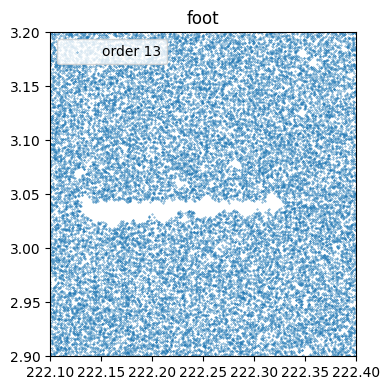

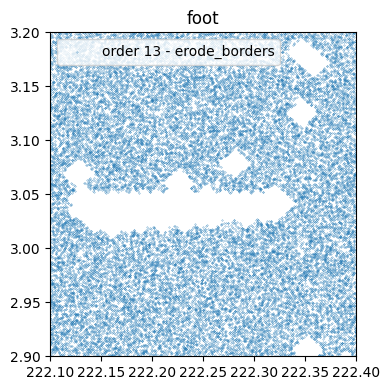

In [16]:
mkp.plot(stage='foot', nr=20_000_000, figsize=[4,4], xwin=[222.1,222.4], ywin=[2.9,3.2],s=0.1)
plt.legend(["order 13"], loc='upper left')
mkp_erode.plot(stage='foot', nr=20_000_000, figsize=[4,4], xwin=[222.1,222.4], ywin=[2.9,3.2],s=0.05)
plt.legend(["order 13 - erode_borders"], loc='upper left')

The large central hole is due to lack of coverage in one of HSC bands. It can be seen that eroding its borders will set its boundary pixels to off (i.e. False). This will result in less mismatch between randoms and real source data (after cutting sources by the mask), at the expense of larger empty zones.

As you can see, isolated empty pixels were also enlarged. Since in most cases these will be caused by small artifacts or faint stars, it would be worth to try to remove them first, and then erode the borders of the remaining holes. In any case, the brigth star mask (pixelized at a larger resolution) can later drill circles of an appropiate size

In [17]:
mkp_isoerode = SkyMaskPipe()
mkp_isoerode.build_footprint_mask(hipcat=HIPCAT, remove_isopixels=True, erode_borders=True)

BUILDING FOOTPRINT MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating hipscat catalog from: ../example_data/hscx_minispring_gal
    Order :: 13
    ...removing isolated pixels...


100%|█████████████████████████████████████████████████████████████████████| 1269519/1269519 [00:09<00:00, 134163.85it/s]


    ...eroding borders...


100%|█████████████████████████████████████████████████████████████████████| 1277209/1277209 [00:06<00:00, 184984.55it/s]

--- Footprint map area                    : 61.246101381829234


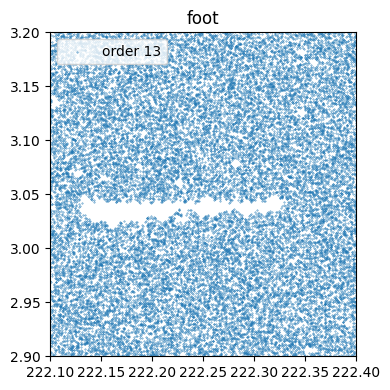

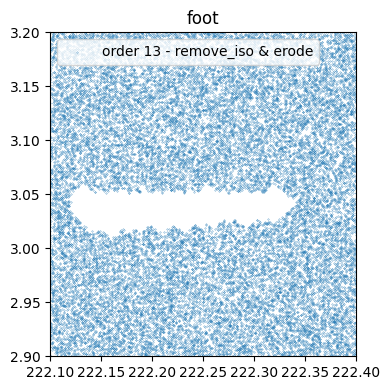

In [18]:
mkp.plot(stage='foot', nr=20_000_000, figsize=[4,4], xwin=[222.1,222.4], ywin=[2.9,3.2],s=0.1)
plt.legend(["order 13"], loc='upper left')
mkp_isoerode.plot(stage='foot', nr=20_000_000, figsize=[4,4], xwin=[222.1,222.4], ywin=[2.9,3.2],s=0.05)
plt.legend(["order 13 - remove_iso & erode"], loc='upper left')

## 2. Creating patch maps
-----------------

In HSC-SSP (and most surveys) you might want to consider areas according to some quality or uniformity criteria. For example you might want regions above a certain depth in order to select a more uniform area, or regions where seeing was good enough for a given purpose. HSC patches have measurements of depth and seeing, by comparing with psf sources detected in Gaia. This information is stored in the [QA table](https://hsc-release.mtk.nao.ac.jp/schema/#pdr3.pdr3_wide.patch_qa) and we will use this to exclude undesirable zones.

A patchmap is no more than the pixelated healsparse map for a list of HSC patches that meet some depth/seeing/etc critera. Of course, you can customize those files and the order of map. The `filt` keyword allows you to enter a set of criteria to select those patches.

<p style="color:tomato">Attribute created --> SkyMaskPipe.patchmap</p>

Setting `filt=None` applies no filtering and therefore all patches will be pixelized into the patchmap. Leaving `filt` unspecified will use the default filtering recipe, which impose minimum values on gri depths in order to select a more uniform coverage :: (gmag_psf_depth>26.2) and (rmag_psf_depth>25.9) and (imag_psf_depth>25.7)

In the example below, we use a custom filter to isolate high or low depth patches in the survey, the later usually located in the border regions that have less visits

In [7]:
mkp1 = SkyMaskPipe()
mkp1.build_patch_mask(patchfile=PATCH_FILE, qafile=QA_FILE, order_patch=13, filt='(imag_psf_depth>25.5)')
mkp2 = SkyMaskPipe()
mkp2.build_patch_mask(patchfile=PATCH_FILE, qafile=QA_FILE, order_patch=13, filt='(imag_psf_depth<25.5)')

BUILDING PATCH MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Processing ../example_data/hsc_aux/tracts_patches_spring.parquet
    Order :: 13
    Patches with QA                       : 29442
    Patches with QA fulfilling conditions : 25625
    Surviving patch pixels                : 13708458
--- Patch map area                        : 702.2352102688099
BUILDING PATCH MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Processing ../example_data/hsc_aux/tracts_patches_spring.parquet
    Order :: 13
    Patches with QA                       : 29442
    Patches with QA fulfilling conditions : 3817
    Surviving patch pixels                : 2271790
--- Patch map area                        : 116.3756659090745


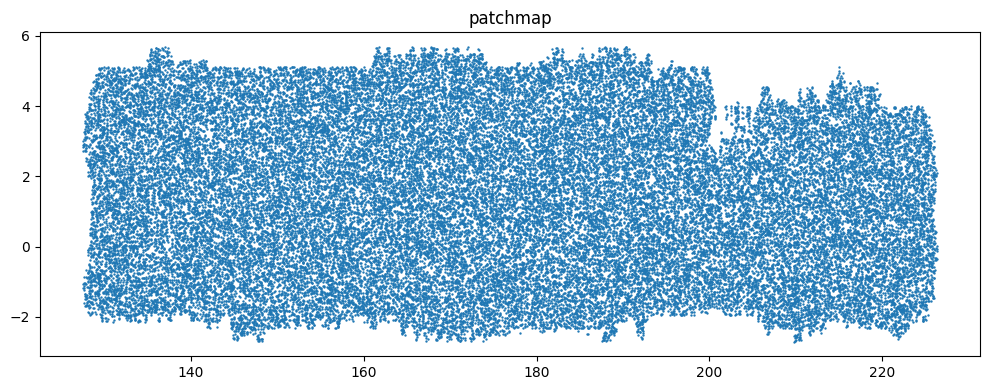

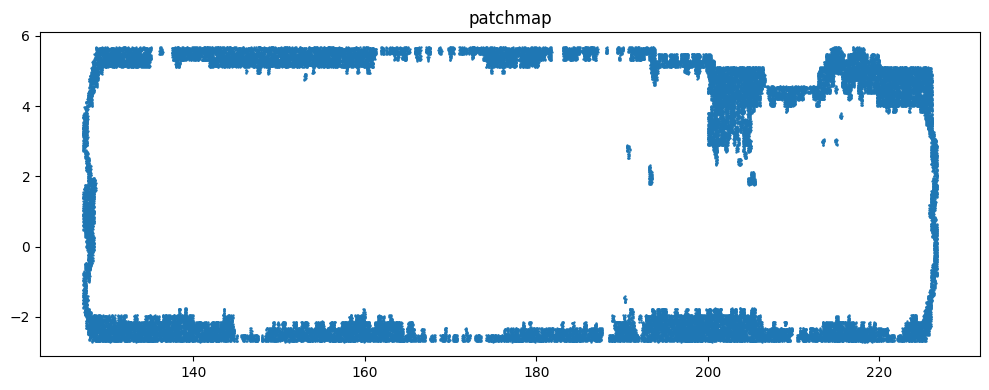

In [9]:
mkp1.plot(stage='patchmap', figsize=[10,4])  # the deep inner part

mkp2.plot(stage='patchmap', figsize=[10,4])  # the shallow border

**Now, lets apply two conditions, one restricting depth and another to remove high density regions**

In [10]:
mkp3 = SkyMaskPipe()
mkp3.build_patch_mask(patchfile=PATCH_FILE, qafile=QA_FILE, order_patch=13, filt='(imag_psf_depth>25.5) and (forced_objects_count<22000)')

BUILDING PATCH MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Processing ../example_data/hsc_aux/tracts_patches_spring.parquet
    Order :: 13
    Patches with QA                       : 29442
    Patches with QA fulfilling conditions : 25100
    Surviving patch pixels                : 13454095
--- Patch map area                        : 689.2051047099202


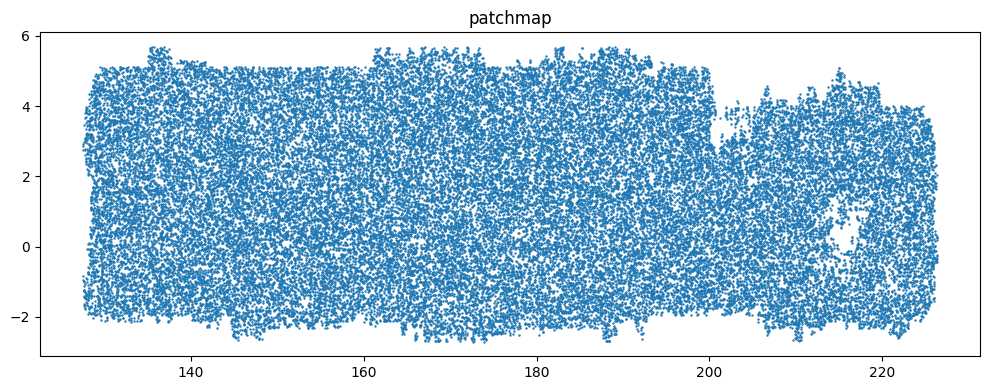

In [11]:
mkp3.plot(stage='patchmap', figsize=[10,4])

## 3. Creating hole maps
-----------------------

Stars can create severe issues in deep 8m-class surveys. The most simple way to deal with them is to drill circles and rectangular boxes, usually proportional to apparent magnitude, around bright stars selected from a catalog. This is the approach taken in HSC-SSP, and we have selected the list of bright stars/boxes updated to DR3 build by the methodology described [here](https://academic.oup.com/pasj/article/70/SP1/S7/4004646). We pixelize these shapes at a relatively high `order_holes` and build a healsparse map using `build_holes_mask()`. 

<p style="color:tomato">Attribute created --> SkyMaskPipe.holemap</p>

The input format for circles/boxes can be customized with `fmt` and the column names too (`columns_circ`, `columns_box`). Despite we call this "hole" map, the pixels created are set to True inside the regions. It is later during the `combine_mask()` phase, that it will be inverted and drilled as actual holes in the mask. 

In [12]:
mkp = SkyMaskPipe()
mkp.build_holes_mask(star_regs=STARS_REGIONS, box_regs=BOX_STARS_REGIONS, order_holes=15)

BUILDING BRIGHT STAR HOLES MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating circles from ../example_data/hsc_aux/stars_iband.parquet
    Order :: 15
    done
--- Pixelating boxes from ../example_data/hsc_aux/starboxes_iband.parquet
    Order :: 15
    done
--- Holes map area                        : 16.295306306474806


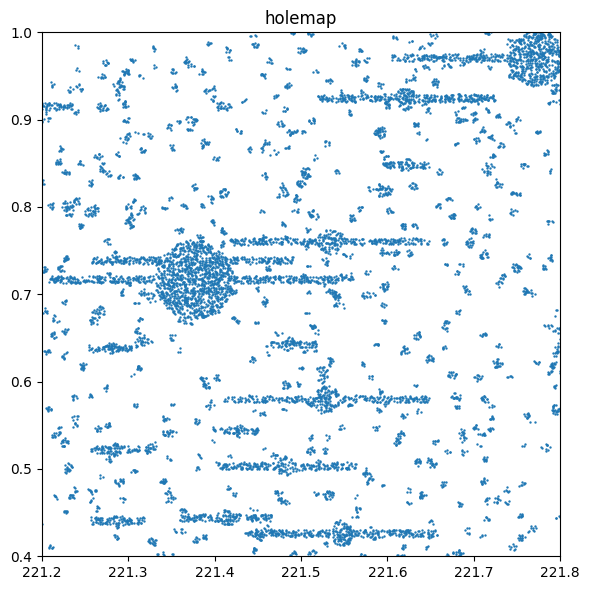

In [16]:
mkp.plot(stage='holemap', nr=3_000_000, figsize=[6,6], xwin=[221.2,221.8], ywin=[0.4,1])

## 4. Creating Extended Maps
---------------------

Extended sources can create some artificial overdensities in wide surveys due to shredding, e.g. a large nearby galaxy gets resolved into multiple sources that enter the catalog. The most simple way to deal with them is to drill ellipses extracted from a suitable catalog. For HSC-SSP we have selected XXX.add.reference.XXX. We pixelize these shapes at a relatively high `order_extended` and build a healsparse map using `build_extended_mask()`. 

<p style="color:tomato">Attribute created --> SkyMaskPipe.extendedmap</p>

The input format for the ellipses list can be customized with `fmt` and the column names too (`columns_circ`, `columns_box`). We call this an "extended" map", but in essence its the same a "hole" map, i.e. the pixels created are set to True inside the regions, which are inverted later during the `combine_mask()` phase. 

## 5. Creating User-defined Maps
-------------------

The user might be interested in working only in certain regions of a survey, so Skykatana provides a way to enter a list of shapes, pixelize them and create a healsparse map by using `build_user_mask()`. These shapes can be circles and/or quadrangular polygons 

<p style="color:tomato">Attribute created --> SkyMaskPipe.usermap</p>

The input format for the regions lists can be customized with `fmt` and the column names too (`columns_ucirc`, `columns_upoly`). For circles they are expected to contain at least 3 columns (for ra, dec and radius). For quadrangular polygonts there are 8 columns to provide (ra and dec for each of the 4 vertexs)